# Experiment

### Detailed Results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import math
import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,5)

NUM_LOGS = 890623051
NUM_REGEX = 17
NUM_REP = 1
ns = [4, 8, 16, 32, 48, 64, 96]
grams = ['bigram', 'baseline']
grams_fp = grams[:-1]
grams_fp_header = ['bigram',]

INDEX_HEADERS = ['NGram', 'Num_Indexed', 'bitvector_index_building_time', 'bitvector_index_size', 'english_bitvector_index_building_time']

DIR_NAME = 'out_7_sys_y'

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
# index building time
bt_df = pd.read_csv(f'{DIR_NAME}/index_building.csv', names=INDEX_HEADERS)  
# bt_df['bitvector_index_size'] = bt_df['bitvector_index_size']/(1024 * 1024)
# bt_df['english_index_size'] = bt_df['english_index_size']/(1024 * 1024)

In [5]:
bt_df

,NGram,Num_Indexed,bitvector_index_building_time,bitvector_index_size,english_bitvector_index_building_time
0,bigram,4,3744.66,7124984432,3980.81
1,bigram,8,4109.18,7124984432,4261.38
2,bigram,16,4066.96,7124984432,4295.24
3,bigram,32,4069.10,7124984432,4292.18
4,bigram,48,4266.30,7124984432,4232.71
5,bigram,64,4006.69,7124984432,3991.15
6,bigram,96,4186.39,14249968840,4424.85
7,bigram,128,4021.62,14249968840,4021.80


In [6]:
def get_num_bits_masked(df, inverted):
    bit_masks = df['filter'].to_list()
    total_count = 0
    for m in bit_masks:
        if inverted:
            total_count += m.count('0')
        else:
            total_count += m.count('1')
    return total_count

In [7]:
fingerprint='bigram'
blare_times = [] 
partial_df = bt_df[bt_df['NGram'] == fingerprint]
line_remains, ave_perc_line_rem, bits_masked = [], [], []
bit_bt_mean, bit_bt_se = [], []
english_bt_mean, english_bt_se = [], []
bt_size, english_size = [], []
ft_mean, ft_se, total_matched = [], [], []
english_mean, english_se = [], []

for num_indexed in ns:
    # for a q-gram signature, with n qgrams indexed,

    # list of 10 experiments
    bit_bt_times = partial_df[partial_df['Num_Indexed'] == num_indexed]['bitvector_index_building_time']
    english_bt_times = partial_df[partial_df['Num_Indexed'] == num_indexed]['english_bitvector_index_building_time']

    bt_sizes = partial_df[partial_df['Num_Indexed'] == num_indexed]['bitvector_index_size']
    english_sizes = partial_df[partial_df['Num_Indexed'] == num_indexed]['bitvector_index_size']

    assert(len(bit_bt_times) == NUM_REP)
    bit_bt_mean.append(np.mean(bit_bt_times))
    english_bt_mean.append(np.mean(english_bt_times))

    bt_size.append(np.mean(bt_sizes))
    english_size.append(np.mean(english_sizes))

    bit_bt_se.append(np.std(bit_bt_times, ddof=1)/np.sqrt(len(bit_bt_times)))
    english_bt_se.append(np.std(english_bt_times, ddof=1)/np.sqrt(len(english_bt_times)))

    filter_times = []
    invert_times = []
    dir_name = f'{DIR_NAME}/new_{fingerprint}_{num_indexed}'

    # Summary csv
    f_name = os.path.join(dir_name, 'summary0.csv')
    sum_df = pd.read_csv(f_name, sep='\t', dtype={'filter': str})

    line_rem_total = sum_df['num_after_filter'].sum()
    line_remains.append(line_rem_total)
    ave_perc_line_rem.append(100*line_rem_total/(NUM_LOGS*NUM_REGEX))

    bits_masked.append(get_num_bits_masked(sum_df, inverted=True))
    curr_filter_matched = sum_df['match_num_filter'].sum()
    curr_english_matched = sum_df['match_num_English'].sum()
    assert(curr_filter_matched == curr_english_matched)

    total_matched.append(curr_filter_matched)

    for subf in os.listdir(dir_name):
        if fingerprint in subf:
            f_name = os.path.join(dir_name, subf)
            df = pd.read_csv(f_name, sep='\t')
            filter_times.append(df['filter_time'].sum())
            blare_times.append(df['direct_time'].sum())
            invert_times.append(df['English_time'].sum())
    if len(filter_times) >= 3:
        filter_times = sorted(filter_times)[1:-1]
        invert_times = sorted(invert_times)[1:-1]
    ft_mean.append(np.mean(filter_times))
    ft_se.append(np.std(filter_times, ddof=1)/np.sqrt(len(filter_times)))
    english_mean.append(np.mean(invert_times))
    english_se.append(np.std(invert_times, ddof=1)/np.sqrt(len(invert_times)))
df = pd.DataFrame(list(zip(ns, line_remains, ave_perc_line_rem, bits_masked, 
                                bit_bt_mean, bit_bt_se,
                                english_bt_mean, english_bt_se,
                                bt_size, english_size,
                                ft_mean, ft_se, 
                                english_mean, english_se,
                                total_matched)), 
                       columns=['Num_Indexed', 'Log_After_Filter', 'Ave_Perc_Log_After_Filter', 'Num_Bits_Masked', 
                                'Bit_Index_Building_Time_Mean(s)', 'Bit_Index_Building_Time_SE(s)',
                                'English_Index_Building_Time_Mean(s)', 'English_Index_Building_Time_SE(s)',
                                'Bit_Index_Size(MB)', 'english_Index_Size(MB)',
                                'Bitvec_Time_Mean(s)', 'Bitvec_Time_SE(s)', 
                                'English_Time_Mean(s)', 'English_Time_SE(s)', 
                                'Num_Matched'])

In [8]:
blare_times = sorted(blare_times)[1:-1]
blare_mean = np.mean(blare_times)
blare_se = np.std(blare_times, ddof=1)/np.sqrt(len(blare_times))

In [9]:
edgecolor_run = '#0173b2'
colors_run = list(reversed(['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b']))

colors_idx = list(reversed(['#fff7ec', '#fee8c8', '#fdd49e', '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#b30000', '#7f0000']))
edgecolor_idx = '#d55e00'

colors_log = list(reversed(['#f7fcfd', '#e0ecf4', '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1' ,'#88419d', '#810f7c', '#4d004b']))
edgecolor_log = '#821580'

In [10]:
def plot_bar_with_err(df, plot_dict, color_map, edge_color, fname_prefix, log_scale=False, baseline=False):
    fig, ax = plt.subplots(figsize=(5.2,3.6))
    plt.grid(axis='y')

    x = np.arange(len(ns))  # the label locations

    gram = 'Bigram Index'
    
    if baseline:
        print(blare_mean)
        y_est = blare_mean * len(x)
        y_err = blare_se * len(x)    
        width = df.shape[0]  # the width of the bars
        rects = ax.bar([x[0]+0.43*width], [blare_mean], width+0.5 , color='gray', label='BLARE-RE2', alpha=0.2)

    width = 0.40
    color = []
    rects = ax.bar(x-0.2, df[plot_dict['col_y1']], width, yerr=None if plot_dict['col_err1'] is None else df[plot_dict['col_err1']], color=color_map[0], edgecolor=edge_color, label='Freq in WL')
    rects = ax.bar(x+0.2, df[plot_dict['col_y2']], width, yerr=None if plot_dict['col_err2'] is None else df[plot_dict['col_err2']], hatch='/', color=color_map[1], edgecolor=edge_color, label='Freq in English')

    ax.set_xticks(x, ns)
    
    maxy = 1.2*np.max([np.max(df[plot_dict['col_y1']].to_list()), np.max(df[plot_dict['col_y2']].to_list())])
    if baseline:
        maxy = 1.1*np.max([blare_mean, maxy])
    if log_scale:
        plt.yscale('log')
        plt.ylim( (pow(10,-1),pow(10,np.log10(maxy))) )
    else:
        plt.ylim(0, maxy)
    
    plt.xlabel(f'Number of Bigrams Indexed')
    plt.ylabel(plot_dict['ylabel'])
    plt.legend(loc=plot_dict['legend_loc'])
    log_scale_tag = '' if not log_scale else '_log'

    plt.savefig(f'figs/Bigram_english_sys_y_{fname_prefix}_errbar_{log_scale_tag}.pdf', bbox_inches = 'tight')

    plt.show()

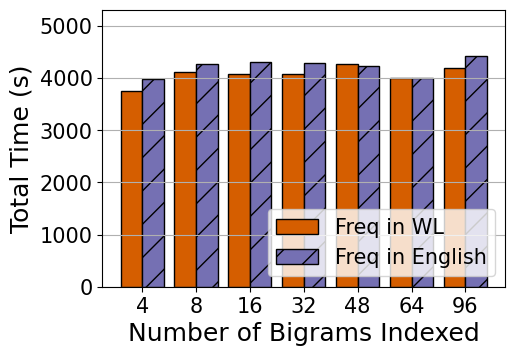

In [11]:
plot_dict= {
    'col_y1': 'Bit_Index_Building_Time_Mean(s)',
    'col_err1': None, #'Bit_Index_Building_Time_SE(s)',
    'col_y2': 'English_Index_Building_Time_Mean(s)',
    'col_err2': None, #'Bit_Index_Building_Time_SE(s)',
    'ylabel': 'Total Time (s)',
    'title': 'Bigram Index Building Time',
    'legend_loc': 'lower right'
}
colors = ['#d55e00', '#7570b3'] 
plot_bar_with_err(df, plot_dict, colors, 'black', fname_prefix='IndexBuilding', log_scale=False, baseline=False)

442.3807


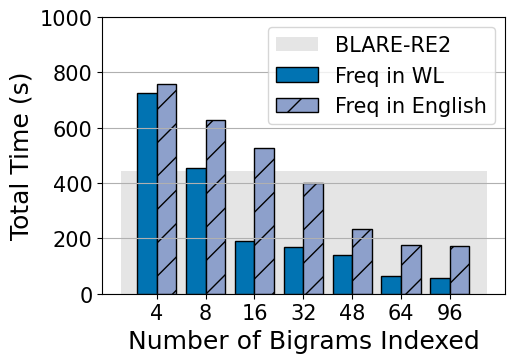

In [12]:
plot_dict= {
    'col_y1': 'Bitvec_Time_Mean(s)',
    'col_err1': 'Bitvec_Time_SE(s)',
    'col_y2': 'English_Time_Mean(s)',
    'col_err2': 'English_Time_SE(s)',
    'ylabel': 'Total Time (s)',
    'title': 'Bigram Filter Runtime',
    'legend_loc': 'best'
}

colors = ['#0173b2', '#8da0cb']
plot_bar_with_err(df, plot_dict, colors, 'black', fname_prefix='SearchTime', log_scale=False, baseline=True)